In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [2]:
# load files
domain2 = pd.read_json("./Data/domain2_train.json", lines = True)
domain1 = pd.read_json("./Data/domain1_train.json", lines = True)

In [3]:
X2_train, X2_test = train_test_split(domain2, test_size=0.2, random_state=90051)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer() 

X2_train_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X2_train['text']]).toarray()
X2_test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X2_test['text']]).toarray()
test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in domain1['text']]).toarray()

## Method 1: Single Model on domain 2
Train a model on domain 2 using Logistic regression, test on domain 1

In [5]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X2_train_vec, X2_train['label'])

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [6]:
print("training score: {}".format(lr.score(X2_train_vec, X2_train['label'])))
print("test score: {}".format(lr.score(X2_test_vec, X2_test['label'])))
print("accuracy on domain 1: {}".format(lr.score(test_vec, domain1['label'])))
# print(classification_report(domain1['label'], lr.predict(test_vec)))

# from sklearn.metrics import ConfusionMatrixDisplay
# cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(domain1['label'], lr.predict(test_vec)))
# cm.plot()

training score: 0.9383389261744967
test score: 0.8060402684563759
accuracy on domain 1: 0.46682051282051285


This model performs badly as the accuracy is low.

## Single Model on domain 2 with label imbalance solved

In [7]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X2_train_vec, X2_train['label'])

print("training score: {}".format(lr.score(X2_train_vec, X2_train['label'])))
print("test score: {}".format(lr.score(X2_test_vec, X2_test['label'])))
print("accuracy on domain 1: {}".format(lr.score(test_vec, domain1['label'])))

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training score: 0.8924496644295302
test score: 0.7204697986577181
accuracy on domain 1: 0.49743589743589745


Accuracy on domain 1 increased slightly, but training and test score decreased more. So this method handling label imbalance is not effective. 

## Method 2: Weighted ensemble
Try to solve the domain problem, using ensemble learning.

$$prediction= \frac{weight_1×prob_1+weight_2×prob_2}{weight_1+weight_2}$$
​where $weight_1$ is the accuracy of model 1 and $weight_2$ is the accuracy of model 2.
 


In [8]:
# Splitting the datasets into training and testing sets
X1_train, X1_test = train_test_split(domain1, test_size=0.2, random_state=90051)
X2_train, X2_test = train_test_split(domain2, test_size=0.2, random_state=90051)

X1_train_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X1_train['text']]).toarray()
X1_test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X1_test['text']]).toarray()
X2_train_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X2_train['text']]).toarray()
X2_test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X2_test['text']]).toarray()

In [13]:
# ensure same number of features for both models
X2_train_vec_trunc = X2_train_vec[:, :X1_train_vec.shape[1]]
X2_test_vec_trunc = X2_test_vec[:, :X1_test_vec.shape[1]]

In [14]:
# Train a logistic regression model on each dataset
model1 = LogisticRegression().fit(X1_train_vec, X1_train['label'])
model2 = LogisticRegression().fit(X2_train_vec_trunc, X2_train['label'])

# Get accuracy on test data for both models
accuracy1 = model1.score(X1_test_vec, X1_test['label'])
accuracy2 = model2.score(X2_test_vec_trunc, X2_test['label'])

accuracy1, accuracy2

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_ite

(0.9102564102564102, 0.8063758389261745)

Fit logistic regression on two domains seperately, the accuracy for domain 1 and domain 2 are 0.9103 and 0.8064 respectively.

In [17]:
def weighted_ensemble_prediction(model1, model2, weight1, weight2, X):
    """Compute weighted ensemble predictions for given input data."""
    proba1 = model1.predict_proba(X)[:, 1]  # Probability for positive class from model 1
    proba2 = model2.predict_proba(X)[:, 1]  # Probability for positive class from model 2
    
    weighted_proba = (weight1 * proba1 + weight2 * proba2) / (weight1 + weight2)
    
    return (weighted_proba > 0.5).astype(int)

# Compute ensemble predictions for test data from both datasets
y1_pred_ensemble = weighted_ensemble_prediction(model1, model2, accuracy1, accuracy2, X1_test_vec)
y2_pred_ensemble = weighted_ensemble_prediction(model1, model2, accuracy1, accuracy2, X2_test_vec_trunc)

# Compute accuracy for ensemble predictions
accuracy1_ensemble = np.mean(y1_pred_ensemble == X1_test['label'])
accuracy2_ensemble = np.mean(y2_pred_ensemble == X2_test['label'])

accuracy1_ensemble, accuracy2_ensemble

(0.8602564102564103, 0.687248322147651)

Using ensemble learning, the accuracy for domain 1 and domain 2 are 0.8603 and 0.6872 respectively.

## Method 3: combine two datasets
try to solve domain problem

training data: all of domain 2 + 80% of domain 1

test data: remaining 20% of domain 1

In [58]:
# Splitting domain 1 into 80% training and 20% testing
X1_train_new, X1_test_new = train_test_split(domain1, test_size=0.2, random_state=90051)

# drop 'model' to have the same strcuture as in domain 1
domain2_new = domain2.drop(columns=['model'])

# Combining all of domain 2 and 80% of domain 1 for the training set
X_train_combined = pd.concat([X1_train_new, domain2_new])

# The test set remains as the 20% from domain 1
X_test_combined = X1_test_new

X_train_combined_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X_train_combined['text']]).toarray()
X_test_combined_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X_test_combined['text']]).toarray()

In [59]:
lr = LogisticRegression()
lr.fit(X_train_combined_vec, X_train_combined['label'])

print("training score: {}".format(lr.score(X_train_combined_vec, X_train_combined['label'])))
print("test score: {}".format(lr.score(X_test_combined_vec, X_test_combined['label'])))

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training score: 0.9019344262295081
test score: 0.8684615384615385


              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1939
           1       0.85      0.89      0.87      1961

    accuracy                           0.87      3900
   macro avg       0.87      0.87      0.87      3900
weighted avg       0.87      0.87      0.87      3900



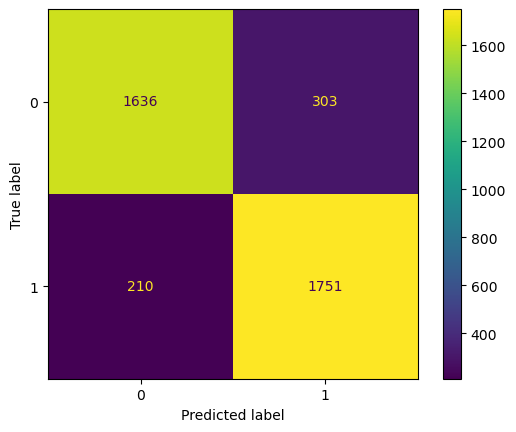

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(X_test_combined['label'], lr.predict(X_test_combined_vec)))
cm.plot()
print(classification_report(X_test_combined['label'], lr.predict(X_test_combined_vec)))

The model has better performance than above ones. Then train on full model to predict test_set
## Kaggle predict

In [48]:
test = pd.read_json("./Data/test_set.json", lines = True)

In [49]:
# Combining all of domain 2 and domain 1 for the training set
train_combined = pd.concat([domain1, domain2_new])

train_combined_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in train_combined['text']]).toarray()
test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in test['text']]).toarray()

In [50]:
lr = LogisticRegression()
lr.fit(train_combined_vec, train_combined['label'])
test_predictions = lr.predict(test_vec)

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [51]:
# Create a DataFrame with IDs and predictions
result_df = pd.DataFrame({
    'id': test['id'],
    'class': test_predictions
})

# Save the results to a CSV file
csv_file_path = "./Data/logistic_domain1+2.csv"
result_df.to_csv(csv_file_path, index=False)

csv_file_path

'./Data/logistic_domain1+2.csv'

## Method 4: Combine two datasets + weighted class
try to solve label imbalance

In [52]:
# Splitting domain 1 into 80% training and 20% testing
X1_train_new, X1_test_new = train_test_split(domain1, test_size=0.2, random_state=90051)

# drop 'model' to have the same strcuture as in domain 1
domain2_new = domain2.drop(columns=['model'])

# Combining all of domain 2 and 80% of domain 1 for the training set
X_train_combined = pd.concat([X1_train_new, domain2_new])

# The test set remains as the 20% from domain 1
X_test_combined = X1_test_new

X_train_combined_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X_train_combined['text']]).toarray()
X_test_combined_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X_test_combined['text']]).toarray()

In [53]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_combined_vec, X_train_combined['label'])

print("training score: {}".format(lr.score(X_train_combined_vec, X_train_combined['label'])))
print("test score: {}".format(lr.score(X_test_combined_vec, X_test_combined['label'])))

c:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


training score: 0.8835409836065574
test score: 0.8753846153846154


              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1939
           1       0.83      0.94      0.88      1961

    accuracy                           0.88      3900
   macro avg       0.88      0.88      0.87      3900
weighted avg       0.88      0.88      0.87      3900



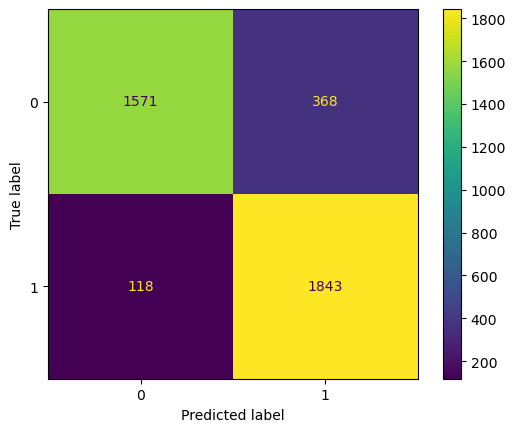

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(X_test_combined['label'], lr.predict(X_test_combined_vec)))
cm.plot()
print(classification_report(X_test_combined['label'], lr.predict(X_test_combined_vec)))

The decrease in traning score is larger than increase in test score. Both instance using LogisticRegression(class_weight='balanced') show little imrpovement.

Logistic regression 尝试了以下方式
1. single model on domain 2, also modified for label imbalance problem, but with little improvement
2. weighted ensemble for domain problem, result is better than method 1
3. combine two datasets, result is significantly better than method 2, kaggle accuracy 0.738
4. modified method 3 for label imbalance problem, little improvement